In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import numpy as np
import glob
from shutil import copyfile
import gdown

In [ ]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 3407
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Stylization

### Get raw cifar dataset 

In [ ]:
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 62.83 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


### Stylize cifar

In [ ]:
!git clone https://github.com/bethgelab/stylize-datasets.git

Cloning into 'stylize-datasets'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 98 (delta 4), reused 1 (delta 0), pack-reused 86
Unpacking objects: 100% (98/98), done.


In [ ]:
# !rm -r cifar-10
!mkdir cifar-10
!mkdir cifar-10/train
!mkdir cifar-10/test

In [ ]:
classes = os.listdir('CIFAR-10-images/train')
classes.sort()
', '.join(classes)

'airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck'

In [ ]:
for i, class_ in enumerate(classes):
    class_images = glob.glob(f'CIFAR-10-images/train/{class_}/*.jpg')
    for image in class_images:
        copyfile(image, f'cifar-10/train/{i}_{image[-8:]}')

In [ ]:
for i, class_ in enumerate(classes):
    class_images = glob.glob(f'CIFAR-10-images/test/{class_}/*.jpg')
    for image in class_images:
        copyfile(image, f'cifar-10/test/{i}_{image[-8:]}')

In [ ]:
assert len(glob.glob(f'cifar-10/train/*.jpg')) + len(glob.glob(f'cifar-10/test/*.jpg')) == 60000

In [ ]:
# !rm -r cifar-10-stylized
!mkdir cifar-10-stylized
!mkdir cifar-10-stylized/train
!mkdir cifar-10-stylized/test

In [ ]:
!gdown --id 1-h8ihPrUmQPWu7vRaUlPFQcXmcTZu_zL

Downloading...
From: https://drive.google.com/uc?id=1-h8ihPrUmQPWu7vRaUlPFQcXmcTZu_zL
To: /content/train_1.zip
100% 5.11G/5.11G [01:27<00:00, 58.4MB/s]


In [ ]:
!mkdir style_images

In [ ]:
!unzip train_1.zip -d style_images

In [ ]:
!rm train_1.zip

In [ ]:
# !rm -r models
!mkdir models

In [ ]:
!gdown --id 11WgiRp-Z-vnz_sCOy1F1Bh4t4oquVkDE --output models/decoder.pth
!gdown --id 1ieEYTE6nIgJLlL01KOmISvCtMdWjVNje --output models/vgg_normalised.pth

Downloading...
From: https://drive.google.com/uc?id=11WgiRp-Z-vnz_sCOy1F1Bh4t4oquVkDE
To: /content/models/decoder.pth
100% 14.0M/14.0M [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ieEYTE6nIgJLlL01KOmISvCtMdWjVNje
To: /content/models/vgg_normalised.pth
100% 80.1M/80.1M [00:00<00:00, 83.0MB/s]


In [ ]:
!python3 stylize-datasets/stylize.py --content-dir '/content/cifar-10/train/' --style-dir '/content/style_images/train_1/' --output-dir '/content/cifar-10-stylized/train/' --style-size 32 --num-styles 6

Original: 

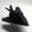

Stylized:

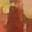
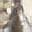
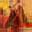
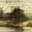
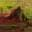
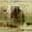

 -----

Original:

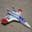

Stylized:

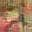
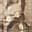
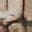
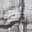
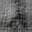
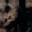

## Resnet18 + synthesized shape/texture dataset

#### Creating a dataset

##### Downloading data

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
!gdown --id 17D_UsYnqgBSPBXm4aQNOxwg6JC1XQlj-

Downloading...
From: https://drive.google.com/uc?id=17D_UsYnqgBSPBXm4aQNOxwg6JC1XQlj-
To: /content/texture.zip
100% 1.93M/1.93M [00:00<00:00, 122MB/s]


In [ ]:
!unzip texture.zip

In [ ]:
!rm -r synt_train
!rm -r synt_test
!mkdir synt_train
!mkdir synt_test

##### Transforming & Merging

In [ ]:
texture_transforms = torch.nn.Sequential(
    # transforms.RandomPosterize(6),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.2),
    transforms.RandomRotation(180),
    transforms.Resize(400),
    transforms.RandomCrop(256),
    # transforms.PILToTensor()
)

form_transforms = torch.nn.Sequential(
    transforms.RandomPerspective(),
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(256, ratio=(0.8, 1.2)),
    # transforms.Resize(256),
    # transforms.PILToTensor(),
)

train_images = 100
test_images = 10

convert_tensor = transforms.ToTensor()
convert_pil = transforms.ToPILImage()

for c in tqdm(range(10)):
    form = Image.open(f"texture/forms/{c}.jpg")
    texture = Image.open(f"texture/textures/{c}.jpg")

    for i in range(train_images):
        while True:
            texture_i = convert_tensor(texture_transforms(texture))
            form_i = convert_tensor(form_transforms(form)).round()
            image = texture_i * form_i
            if (image > 0.5 * torch.ones(3, 256, 256)).sum() > 1000:
                break
        pil_image = convert_pil(image)
        pil_image.save(f"synt_train/{c}_{i}.jpg")

    for i in range(test_images):
        while True:
            texture_i = convert_tensor(texture_transforms(texture))
            form_i = convert_tensor(form_transforms(form))
            image = texture_i * form_i
            if (image > 0.5 * torch.ones(3, 256, 256)).sum() > 1000:
                break
        pil_image = convert_pil(image)
        pil_image.save(f"synt_test/{c}_{i}.jpg")


100%|██████████| 10/10 [01:45<00:00, 10.55s/it]


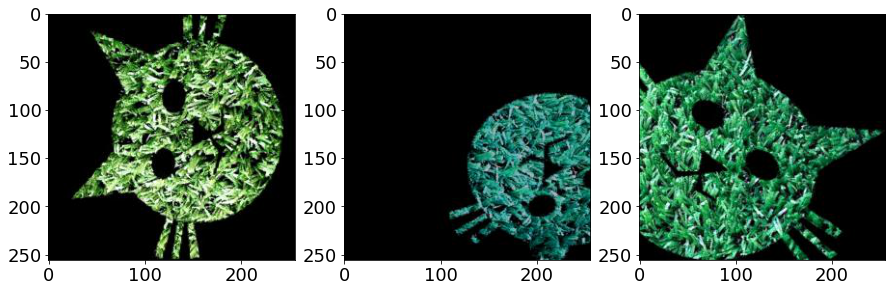

In [ ]:
f, axarr = plt.subplots(1, 3, )
f.set_figheight(15)
f.set_figwidth(15)

c = 4
for i in range(3):
    axarr[i].imshow(Image.open(f"synt_test/{c}_{i}.jpg"))
plt.show()

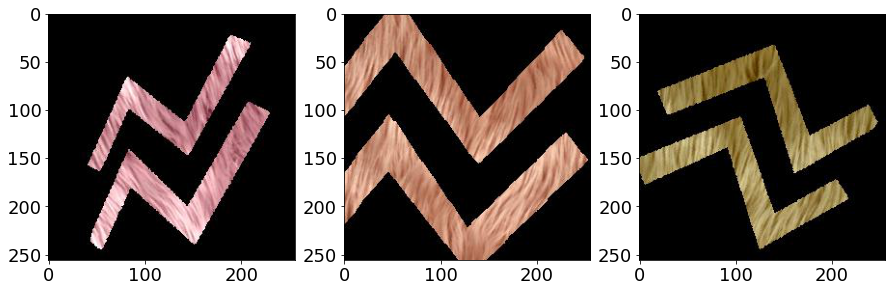

In [ ]:
f, axarr = plt.subplots(1, 3)
f.set_figheight(15)
f.set_figwidth(15)

c = 5
for i in range(3):
    axarr[i].imshow(Image.open(f"synt_train/{c}_{i}.jpg"))
plt.show()

##### Loaders

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        self.img_dir = 'synt_' + mode
        self.mode = mode
        self.transform = transform
        if mode == 'train':
            self.per_class_images = train_images
        else:
            self.per_class_images = test_images

    def __len__(self):
        return self.per_class_images * 10

    def __getitem__(self, idx):
        if idx >= self.__len__():
            raise IndexError
        img_path = self.img_dir + f'/{idx // self.per_class_images}_{idx % self.per_class_images}.jpg'
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return convert_tensor(image), idx // self.per_class_images

In [ ]:
train_dataset = MyDataset()
test_dataset = MyDataset('test')

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### Training

In [ ]:
from time import time

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=False, num_classes=10).to(device)

In [ ]:
def count_acc(loader, criterion=nn.CrossEntropyLoss()):
    correct = 0
    total = 0
    total_loss = 0
    # since we're not training, we don't need to calculate the gradients for
    # our outputs
    resnet18.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = resnet18(images)
            total_loss += criterion(outputs, labels).item()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total, total_loss / len(loader)

In [ ]:
epochs = 15

optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_steps = epochs * len(train_dataloader)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[lr_steps // 2, (3 * lr_steps) // 4], gamma=0.1)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    opening = time()
    resnet18.train()
    for i, (X, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        output = resnet18(X)
        loss = criterion(output, y)
        loss.backward()

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        
    lr = scheduler.get_last_lr()[0]
    val_acc, val_loss = count_acc(test_dataloader)
    print('loss', running_loss / len(train_dataloader),
            '\n\tacc', count_acc(train_dataloader)[0],
            '\nval_loss', val_loss,
            '\n\tval_acc', val_acc, '\nepoch', epoch, '\tlr', lr,
            '\ttime', time() - opening)

100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


loss 2.197844311594963 
	acc 0.169 
val_loss 2.297678232192993 
	val_acc 0.12 
epoch 0 	lr 0.01 	time 18.460519790649414


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


loss 1.6319395303726196 
	acc 0.317 
val_loss 2.1919727325439453 
	val_acc 0.28 
epoch 1 	lr 0.01 	time 18.3021023273468


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


loss 1.0587709471583366 
	acc 0.255 
val_loss 2.6408896446228027 
	val_acc 0.23 
epoch 2 	lr 0.01 	time 18.387105226516724


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


loss 0.7084377929568291 
	acc 0.246 
val_loss 3.5815415382385254 
	val_acc 0.26 
epoch 3 	lr 0.01 	time 18.494266271591187


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


loss 0.49991941452026367 
	acc 0.629 
val_loss 1.0378304719924927 
	val_acc 0.62 
epoch 4 	lr 0.01 	time 18.386463403701782


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


loss 0.4387023523449898 
	acc 0.39 
val_loss 3.970914840698242 
	val_acc 0.39 
epoch 5 	lr 0.01 	time 18.35560631752014


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


loss 0.3720010481774807 
	acc 0.473 
val_loss 2.113454580307007 
	val_acc 0.48 
epoch 6 	lr 0.01 	time 18.44753885269165


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


loss 0.32317166216671467 
	acc 0.642 
val_loss 1.5021989345550537 
	val_acc 0.62 
epoch 7 	lr 0.001 	time 18.500759840011597


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


loss 0.24734162166714668 
	acc 0.839 
val_loss 0.6445826888084412 
	val_acc 0.8 
epoch 8 	lr 0.001 	time 18.47697687149048


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


loss 0.2228388525545597 
	acc 0.932 
val_loss 0.33111485838890076 
	val_acc 0.89 
epoch 9 	lr 0.001 	time 18.454115390777588


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


loss 0.2269451655447483 
	acc 0.781 
val_loss 0.6265212893486023 
	val_acc 0.85 
epoch 10 	lr 0.001 	time 18.523078680038452


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


loss 0.15594551898539066 
	acc 0.972 
val_loss 0.21410968899726868 
	val_acc 0.94 
epoch 11 	lr 0.0001 	time 18.52913999557495


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


loss 0.16571372840553522 
	acc 0.976 
val_loss 0.22569014132022858 
	val_acc 0.94 
epoch 12 	lr 0.0001 	time 18.566237926483154


100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


loss 0.1476555746048689 
	acc 0.972 
val_loss 0.23076820373535156 
	val_acc 0.93 
epoch 13 	lr 0.0001 	time 18.470272064208984


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


loss 0.1753872660920024 
	acc 0.975 
val_loss 0.22210146486759186 
	val_acc 0.93 
epoch 14 	lr 0.0001 	time 18.564375638961792


#### Texture-Shape test dataset

In [ ]:
!rm -r synt_ts_test
!mkdir synt_ts_test

rm: cannot remove 'synt_ts_test': No such file or directory


In [ ]:
ts_test_images = 4

In [ ]:
for c in tqdm(range(10)):
    form = Image.open(f"texture/forms/{c}.jpg")

    for i in range(10):
        if i == c:
            continue
        texture = Image.open(f"texture/textures/{i}.jpg")
        for k in range(ts_test_images):
            while True:
                texture_i = convert_tensor(texture_transforms(texture))
                form_i = convert_tensor(form_transforms(form)).round()
                image = texture_i * form_i

                if (image > 0.5 * torch.ones(3, 256, 256)).sum() > 1000:
                    break
            pil_image = convert_pil(image)
            pil_image.save(f"synt_ts_test/{c}_{i}_{k}.jpg")
 

100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


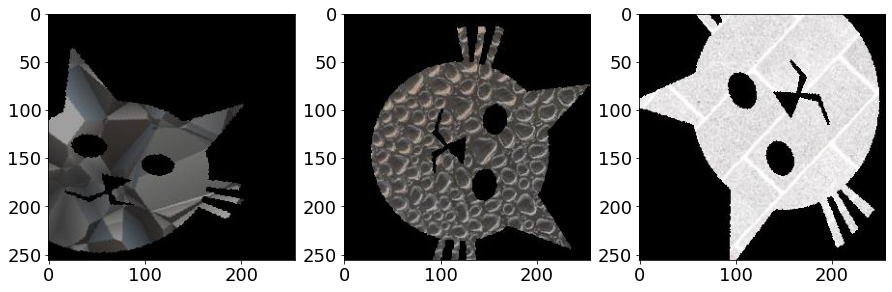

In [ ]:
f, axarr = plt.subplots(1, 3)
f.set_figheight(15)
f.set_figwidth(15)

c = 4
for i in range(3):
    axarr[i].imshow(Image.open(f"synt_ts_test/{c}_{i}_{0}.jpg"))
plt.show()

In [ ]:
class MyTSDataset(Dataset):
    def __init__(self, transform=None):
        self.img_dir = 'synt_ts_test'
        self.transform = transform
        self.per_class_images = 9
        self.images = glob.glob(self.img_dir + '/*.jpg')
        self.images.sort()
        
    def __len__(self):
        return self.per_class_images * 10 * ts_test_images

    def __getitem__(self, idx):
        if idx >= self.__len__():
            raise IndexError
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        shape_label, texture_label, _ = img_path.split('/')[-1].split('_')
        return convert_tensor(image), int(shape_label), int(texture_label)

In [ ]:
ts_test_dataset = MyTSDataset()
len(ts_test_dataset)

360

0 1


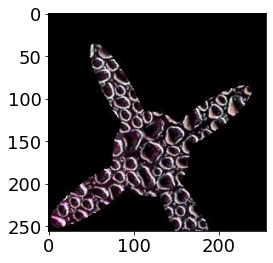

In [ ]:
image, shape_label, texture_label = ts_test_dataset[2]
print(shape_label, texture_label)
plt.imshow(convert_pil(image))

In [ ]:
ts_batch_size = 64
ts_test_dataloader = DataLoader(ts_test_dataset, batch_size=ts_batch_size, shuffle=True)

### Result

In [ ]:
shape_correct, texture_correct = 0, 0
total = 0

resnet18.eval()
with torch.no_grad():
    for data in ts_test_dataloader:
        images, shape_labels, texture_labels = data
        images, shape_labels, texture_labels = images.to(device), shape_labels.to(device), texture_labels.to(device)
        # calculate outputs by running images through the network
        outputs = resnet18(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += shape_labels.size(0)
        shape_correct += (predicted == shape_labels).sum().item()
        texture_correct += (predicted == texture_labels).sum().item()

shape_accuracy = shape_correct / total
texture_accuracy = texture_correct / total

In [ ]:
print(f'shape accuracy:\t\t{shape_accuracy}\ntexture accuracy:\t{texture_accuracy}\ntexture bias:\t\t{texture_correct/(shape_correct + texture_correct)}')

shape accuracy:		0.025
texture accuracy:	0.8527777777777777
texture bias:		0.9715189873417721


## Other Architectures

### Loading pretrained models

#### ResNet50, DenseNet, VGG

In [ ]:
import os
import sys
from collections import OrderedDict
import torch
import torchvision
import torchvision.models
from torch.utils import model_zoo

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
densenet = torchvision.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

#### ViT, Twins

Twins: recent transformer architecture, has two types of attention operations (like separable convolutions, but separable attentions)

In [ ]:
!git clone https://github.com/rwightman/pytorch-image-models.git

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 9216, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 9216 (delta 160), reused 178 (delta 116), pack-reused 8954
Receiving objects: 100% (9216/9216), 18.26 MiB | 27.87 MiB/s, done.
Resolving deltas: 100% (6788/6788), done.


In [ ]:
%cd /content/pytorch-image-models/

/content/pytorch-image-models


In [ ]:
from timm.models.vision_transformer import vit_base_patch32_224
vit = vit_base_patch32_224(pretrained=True)

In [ ]:
from timm.models.twins import twins_pcpvt_base
twins = twins_pcpvt_base(True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vt3p-weights/twins_pcpvt_base-e5ecb09b.pth" to /root/.cache/torch/hub/checkpoints/twins_pcpvt_base-e5ecb09b.pth


#### MLP-Mixer, Conv-Mixer

In [ ]:
from timm.models.mlp_mixer import mixer_l16_224
mlp_mixer = mixer_l16_224(True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_mixer_l16_224-92f9adc4.pth" to /root/.cache/torch/hub/checkpoints/jx_mixer_l16_224-92f9adc4.pth


In [ ]:
from timm.models.convmixer import convmixer_1536_20
conv_mixer = convmixer_1536_20(True)

Downloading: "https://github.com/tmp-iclr/convmixer/releases/download/timm-v1.0/convmixer_1536_20_ks9_p7.pth.tar" to /root/.cache/torch/hub/checkpoints/convmixer_1536_20_ks9_p7.pth.tar


#### EfficientNet

In [ ]:
from timm.models.efficientnet import efficientnet_b4 as effnet
efficient_net = effnet(True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth


In [ ]:
%cd /content/

/content


### Dataset

In [ ]:
!git clone https://github.com/rgeirhos/texture-vs-shape.git

Cloning into 'texture-vs-shape'...
remote: Enumerating objects: 2365, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 2365 (delta 26), reused 72 (delta 11), pack-reused 2210
Receiving objects: 100% (2365/2365), 148.66 MiB | 19.02 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [ ]:
classes = os.listdir('texture-vs-shape/stimuli/style-transfer-preprocessed-512')
classes.sort()
', '.join(classes)

'airplane, bear, bicycle, bird, boat, bottle, car, cat, chair, clock, dog, elephant, keyboard, knife, oven, truck'

In [ ]:
# !rm -r stimuli
!mkdir stimuli

In [ ]:
j = 0
for i, class_ in enumerate(classes):
    class_images = glob.glob(f'texture-vs-shape/stimuli/style-transfer-preprocessed-512/{class_}/*.png')
    for image in class_images:
        second_class = [cl in image.split('/')[-1].split('-')[-1] for cl in classes].index(1)
        if i != second_class:
            copyfile(image, f'stimuli/{j}_{i}_{second_class}.png')
            j += 1

### Loader

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class MyStimuliDataset(Dataset):
    def __init__(self, transform=None):
        self.img_dir = '/content/stimuli'
        self.transform = transform
        self.images = glob.glob(self.img_dir + '/*.png')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx >= self.__len__():
            raise IndexError
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        _, shape_label, texture_label = img_path.split('.')[0].split('_')
        return image, int(shape_label), int(texture_label)

In [ ]:
stimuli_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

stimuli_vit_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

stimuli_dataset = MyStimuliDataset(transform=stimuli_transform)
stimuli_dataloader = DataLoader(stimuli_dataset, 64)

Bear / Botttles:

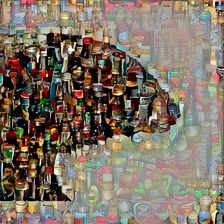

Oven / Elephant:

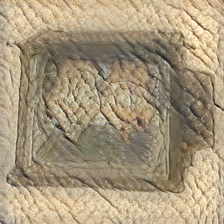

Chair / Clock:

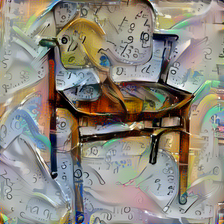

### Obtaining results

In [ ]:
%cd texture-vs-shape/code

[Errno 2] No such file or directory: 'texture-vs-shape/code'
/content/texture-vs-shape/code


In [ ]:
import probabilities_to_decision

In [ ]:
def texture_bias(model):
    model = model.to(device)
    model.eval()

    shape_correct = 0
    texture_correct = 0

    with torch.no_grad():
        for el in stimuli_dataset:
            image, shape_label, texture_label = el
            image = image.to(device)
            shape = classes[shape_label]
            texture = classes[texture_label]
            
            # print(image.shape)
            softmax_output = nn.Softmax()(model(image.unsqueeze(0).to(device)))

            softmax_output_numpy = softmax_output.detach().cpu().numpy()[0]
            # print(softmax_output_numpy.shape)

            mapping = probabilities_to_decision.ImageNetProbabilitiesTo16ClassesMapping()

            decision_from_16_classes = mapping.probabilities_to_decision(softmax_output_numpy)

            shape_correct += decision_from_16_classes == shape
            texture_correct += decision_from_16_classes == texture

    return texture_correct / (texture_correct + shape_correct), texture_correct / len(stimuli_dataset), shape_correct / len(stimuli_dataset)

In [ ]:
res = {}

In [ ]:
res['mlp_mixer'] = texture_bias(mlp_mixer)

In [ ]:
res['conv_mixer'] = texture_bias(conv_mixer)

In [ ]:
res['vit'] = texture_bias(vit)

In [ ]:
res['resnet50'] = texture_bias(resnet50)

In [ ]:
res['densenet'] = texture_bias(densenet)

In [ ]:
res['vgg16'] = texture_bias(vgg16)

In [ ]:
res['twins'] = texture_bias(twins)

In [ ]:
res['efficient_net'] = texture_bias(efficient_net)

In [ ]:
res['random'] = (0.5, 1 / len(classes), 1 / len(classes))

In [ ]:
%cd /content/

/content


### Visualization

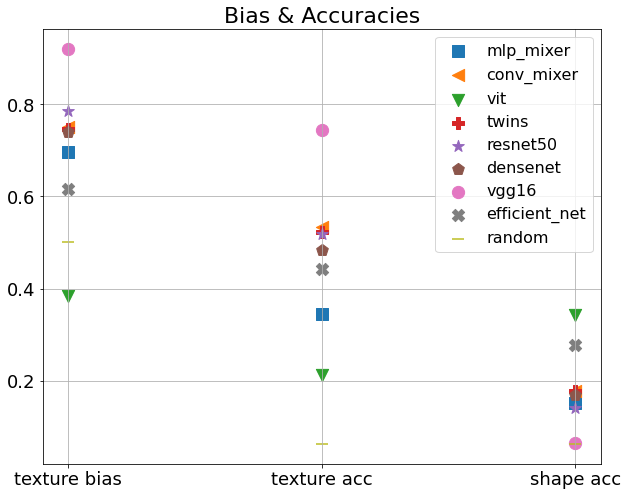

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('axes', titlesize=22)

markers = ['s', "<", "v", "P", "*", "p", "o", "X", "_"]

plt.figure(figsize=(10, 8))
plt.grid(True, 'major')

for i, (k, v) in enumerate(res.items()):
    plt.scatter(list(range(3)), v, marker=markers[i], s=150, label=k)

plt.legend()
plt.xticks(list(range(3)), ('texture bias', 'texture acc', 'shape acc'))
plt.title('Bias & Accuracies', )
plt.show()